# Tarea 2 Ingeniería Financiera

Este Notebook contiene el análisis completo seccionado por pregunta.

In [ ]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\Leandro\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\Leandro\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# filepath: /Users/leandrovenegas/Documents/GitHub/Uni/tarea2.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
### Setup: Lectura de datos
# Leer todas las hojas del archivo Excel
ruta_archivo = "Base de datos completa.xlsx"  # Ajustar ruta si es necesario
datos = pd.read_excel(ruta_archivo, sheet_name=None)

In [4]:
# Mostrar las primeras filas de cada hoja
for hoja, df in datos.items():
    print(f"Hoja: {hoja}")
    print(df.head())

Hoja: Tipo de Cambio
        Date   Price
0 2022-04-25  834.45
1 2022-04-26  850.85
2 2022-04-27  847.57
3 2022-04-28  847.44
4 2022-04-29  856.58
Hoja: Apple Stock Price History (3)
        Date   Price
0 2022-04-25  162.88
1 2022-04-26  156.80
2 2022-04-27  156.57
3 2022-04-28  163.64
4 2022-04-29  157.65
Hoja: Coca-Cola Stock Price History (
        Date  Price
0 2022-04-25  65.94
1 2022-04-26  65.05
2 2022-04-27  65.56
3 2022-04-28  66.19
4 2022-04-29  64.61
Hoja: Banco De Chile Stock Price Hist
        Date  Price
0 2022-04-25  20.95
1 2022-04-26  20.67
2 2022-04-27  20.60
3 2022-04-28  20.14
4 2022-04-29  20.08
Hoja: Cervecerias ADR Stock Price His
        Date  Price
0 2022-04-25  13.40
1 2022-04-26  13.34
2 2022-04-27  13.37
3 2022-04-28  13.37
4 2022-04-29  13.34
Hoja: Enel Chile ADR Stock Price Hist
        Date  Price
0 2022-04-25   1.42
1 2022-04-26   1.36
2 2022-04-27   1.33
3 2022-04-28   1.36
4 2022-04-29   1.34
Hoja: LATAM Airlines ADR Stock Price 
        Date    Price

In [5]:
log_returns = {}

# Preparar tipo de cambio si existe
exchange_rate = datos.get("Tipo de Cambio")
if exchange_rate is not None and not exchange_rate.empty:
    exchange_rate['Date'] = pd.to_datetime(exchange_rate['Date'])
    exchange_rate.sort_values('Date', inplace=True)

# Procesar cada hoja de datos
for asset, df in datos.items():
    # Omitir hoja de tipo de cambio o data inválida
    if asset == "Tipo de Cambio" or df.empty or 'Date' not in df.columns or 'Price' not in df.columns:
        continue

    # Convertir fechas y ordenar
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)

    # Ajustar precios a pesos si existe tipo de cambio
    if exchange_rate is not None and not exchange_rate.empty:
        df = pd.merge(df, exchange_rate[['Date', 'Price']], on='Date', how='left', suffixes=('', '_tc'))
        df['Price'] *= df['Price_tc']  # Convertir a pesos

    # Filtrar datos hasta un año antes de la última fecha disponible
    cutoff = df['Date'].max() - pd.DateOffset(years=1)
    df = df[df['Date'] <= cutoff].copy()

    # Calcular retornos logarítmicos diarios
    df['log_return'] = np.log(df['Price'] / df['Price'].shift(1))

    # Guardar resultados sin valores nulos
    log_returns[asset] = df.dropna(subset=['log_return'])


In [6]:
expected_returns_annual = {}
volatility_annual = {}

# Anualización de estadísticas diarias (252 días hábiles al año)
for asset, df in log_returns.items():
    mu = df['log_return'].mean() #Retorno promedio
    sigma = df['log_return'].std() #Desviación.
    expected_returns_annual[asset] = mu * 252
    volatility_annual[asset] = sigma * np.sqrt(252)

# Mostrar resultados
print("Retornos esperados anuales:")
for asset, r in expected_returns_annual.items():
    print(f"{asset}: {r:.4%}")

print("\n Volatilidades anuales:")
for asset, v in volatility_annual.items():
    print(f"{asset}: {v:.4%}")


Retornos esperados anuales:
Apple Stock Price History (3): 6.4235%
Coca-Cola Stock Price History (: -0.9920%
Banco De Chile Stock Price Hist: 8.0665%
Cervecerias ADR Stock Price His: 3.2947%
Enel Chile ADR Stock Price Hist: 37.6500%
LATAM Airlines ADR Stock Price : 70.9913%

 Volatilidades anuales:
Apple Stock Price History (3): 31.7011%
Coca-Cola Stock Price History (: 22.7095%
Banco De Chile Stock Price Hist: 31.5361%
Cervecerias ADR Stock Price His: 33.8403%
Enel Chile ADR Stock Price Hist: 48.4899%
LATAM Airlines ADR Stock Price : 107.5772%


In [7]:
# Armar DataFrame de retornos alineado por fecha
returns_df = pd.DataFrame({
    asset: df.set_index('Date')['log_return'] for asset, df in log_returns.items()
})

returns_df.dropna(inplace=True)  # Alinear fechas comunes


## (b) Cartera de mínima varianza y (c) Recomendación: Cartera de mínimo riesgo

La siguiente celda estima la cartera de mínima varianza (parte de la frontera eficiente) y emite una recomendación.

In [8]:
# Calcular matriz de covarianza anualizada
cov_annual = returns_df.cov() * 252

In [9]:
# Convertir a arrays para cálculos matriciales
mu = np.array([expected_returns_annual[asset] for asset in returns_df.columns])
Sigma = cov_annual.values
ones = np.ones(len(mu))

# Cálculo de escalares a, b, c, d
Sigma_inv = np.linalg.inv(Sigma)
a = ones.T @ Sigma_inv @ mu
b = mu.T @ Sigma_inv @ mu
c = ones.T @ Sigma_inv @ ones
d = b * c - a**2

# Cálculo de vectores g y h
g = (c * Sigma_inv @ mu - a * Sigma_inv @ ones) / d
h = (b * Sigma_inv @ ones - a * Sigma_inv @ mu) / d



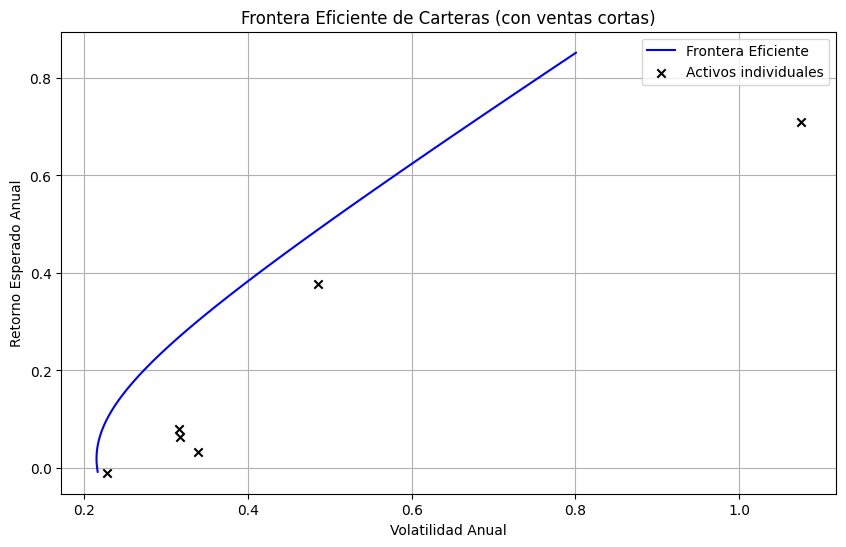

In [10]:
# Rango de retornos anuales para construir la frontera
r_vals = np.linspace(min(mu) * 0.8, max(mu) * 1.2, 100)

# Calcular volatilidades asociadas a cada retorno
vol_vals = np.sqrt((c * r_vals**2 - 2 * a * r_vals + b) / d)

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(vol_vals, r_vals, label='Frontera Eficiente', color='blue')
plt.scatter(np.sqrt(np.diag(Sigma)), mu, color='black', marker='x', label='Activos individuales')
plt.xlabel('Volatilidad Anual')
plt.ylabel('Retorno Esperado Anual')
plt.title('Frontera Eficiente de Carteras (con ventas cortas)')
plt.grid(True)
plt.legend()
plt.show()


In [11]:
#Parte c# Retorno y riesgo del portafolio de mínima varianza (teóricamente óptimo)
r_minvar = a / c
sigma_minvar = np.sqrt(1 / c)
w_minvar = r_minvar * g + h

print("Recomendación de cartera de mínimo riesgo (parte c):")
print(f"Retorno esperado anual: {r_minvar:.2%}")
print(f"Volatilidad anual: {sigma_minvar:.2%}")
print("Pesos del portafolio:")
for asset, weight in zip(returns_df.columns, w_minvar):
    print(f"  {asset}: {weight:.2%}")


Recomendación de cartera de mínimo riesgo (parte c):
Retorno esperado anual: 1.88%
Volatilidad anual: 21.48%
Pesos del portafolio:
  Apple Stock Price History (3): 9.58%
  Coca-Cola Stock Price History (: 69.32%
  Banco De Chile Stock Price Hist: 23.04%
  Cervecerias ADR Stock Price His: -1.71%
  Enel Chile ADR Stock Price Hist: -0.96%
  LATAM Airlines ADR Stock Price : 0.72%


## (d) Cartera tangente con tasa libre de riesgo

Se utiliza una tasa libre de riesgo (por ejemplo, 5.75% por cambiar) para obtener la cartera tangente.

In [12]:
# Tasa libre de riesgo anual (en decimales)
r_f = 0.0575  # 5.75%, por ejemplo para un BCP a 1 año


In [13]:
# Maximizar Sharpe Ratio => tangente a la frontera eficiente
# Encontramos el r que maximiza (r - r_f) / sigma(r)
sharpe_ratios = []
r_vals = np.linspace(min(mu)*0.8, max(mu)*1.2, 100)
best_r, best_w, best_sigma = None, None, None

for r in r_vals:
    w_r = r * g + h
    sigma_r = np.sqrt(w_r.T @ Sigma @ w_r)
    sharpe = (r - r_f) / sigma_r
    sharpe_ratios.append(sharpe)

    if best_r is None or sharpe > max(sharpe_ratios[:-1]):
        best_r, best_w, best_sigma = r, w_r, sigma_r

print("\nCartera tangente (parte d):")
print(f"Tasa libre de riesgo: {r_f:.2%}")
print(f"Retorno esperado: {best_r:.2%}")
print(f"Volatilidad anual: {best_sigma:.2%}")
print("Pesos del portafolio:")
for asset, weight in zip(returns_df.columns, best_w):
    print(f"  {asset}: {weight:.2%}")



Cartera tangente (parte d):
Tasa libre de riesgo: 5.75%
Retorno esperado: 85.19%
Volatilidad anual: 80.07%
Pesos del portafolio:
  Apple Stock Price History (3): 48.66%
  Coca-Cola Stock Price History (: -99.64%
  Banco De Chile Stock Price Hist: 24.80%
  Cervecerias ADR Stock Price His: -49.31%
  Enel Chile ADR Stock Price Hist: 131.61%
  LATAM Airlines ADR Stock Price : 43.87%


## (e) Cartera de mercado y betas

Se asume que la cartera de mercado es la cartera tangente calculada en (d). Se calcula el retorno y la volatilidad anual, y se estima el beta de cada activo.

In [14]:
w_market = best_w           # cartera tangente = cartera de mercado
r_market = best_r           # retorno esperado
sigma_market = best_sigma   # desviación estándar


In [15]:
# Producto Sigma * w_market
Sigma_w = Sigma @ w_market
var_market = w_market.T @ Sigma @ w_market
betas = {asset: Sigma_w[i] / var_market for i, asset in enumerate(returns_df.columns)}

print("Resultados parte (e):")
print(f"Retorno esperado del mercado: {r_market:.2%}")
print(f"Volatilidad del mercado: {sigma_market:.2%}")
print("Pesos del portafolio de mercado:")
for asset, weight in zip(returns_df.columns, w_market):
    print(f"  {asset}: {weight:.2%}")
print("Betas de los activos:")
for asset, beta in betas.items():
    print(f"  {asset}: {beta:.4f}")


Resultados parte (e):
Retorno esperado del mercado: 85.19%
Volatilidad del mercado: 80.07%
Pesos del portafolio de mercado:
  Apple Stock Price History (3): 48.66%
  Coca-Cola Stock Price History (: -99.64%
  Banco De Chile Stock Price Hist: 24.80%
  Cervecerias ADR Stock Price His: -49.31%
  Enel Chile ADR Stock Price Hist: 131.61%
  LATAM Airlines ADR Stock Price : 43.87%
Betas de los activos:
  Apple Stock Price History (3): 0.1225
  Coca-Cola Stock Price History (: 0.0399
  Banco De Chile Stock Price Hist: 0.1409
  Cervecerias ADR Stock Price His: 0.0877
  Enel Chile ADR Stock Price Hist: 0.4704
  LATAM Airlines ADR Stock Price : 0.8418


Discusión del supuesto en (a):
En (a) asumiste que los retornos esperados eran simplemente la media histórica anual de los log-retornos. Sin embargo, el CAPM implica que los retornos esperados deben estar alineados con los betas:

𝐸[𝑟_𝑖]=𝑟_𝑓+𝛽_𝑖(𝐸[𝑟_𝑚]−𝑟_𝑓)

Podrías comparar los retornos empíricos vs. los retornos esperados por CAPM para validar o ajustar.

## (f) Optimización sin ventas cortas

Utilizando `scipy.optimize.minimize`, se optimiza la cartera de mínima varianza y la tangente imponiendo que todos los pesos sean mayores o iguales a cero y que sumen 1.

In [20]:
pip install scipy

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.8 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 459.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ---------------------------------------- 0.1/41.2 MB 3.5 MB/s eta 0:00:12
   ---------------------------------------- 0.2/41.2 MB 3.7 MB/s eta 0:00:12
   ---------------------------------------- 0.2/41.2 MB 2.1 MB/s eta 0:00:20
   ---------------------------------------- 0.4/41.2 MB 2.1 MB/s eta 0:00:20
    --------------------------------------- 0.6/41.2 MB 2.6 MB/s eta 0:00:16
   - -------------------------------------- 1.6/41.2 MB 6.2 MB/s eta 0:00:07
   ---- ----------------------------------- 4.4/41.2 MB 14.0 MB/s eta 0:00:03
   ------- -------------------------------- 8.1/41.2 MB 22.4 MB/s eta 0:00:02
   ----


[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\Leandro\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [21]:
from scipy.optimize import minimize
import numpy as np

# Número de activos
n = len(returns_df.columns)

# Restricciones básicas: sin ventas cortas y suma de pesos = 1
bounds = [(0, 1) for _ in range(n)]
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

# Función objetivo: minimizar la varianza del portafolio
def min_vol_objective(w):
    return w.T @ cov_annual.values @ w

# Optimizador generalizado para un retorno objetivo
def optimize_portfolio_target(target_return):
    cons = constraints + [{'type': 'eq', 'fun': lambda w: sum(w[i] * expected_returns_annual[asset] for i, asset in enumerate(returns_df.columns)) - target_return}]
    res = minimize(min_vol_objective, np.ones(n)/n, bounds=bounds, constraints=cons)
    return res.x if res.success else None

# Definir retornos objetivos
target_low = port_return_min_ns + 0.0005
target_med = (port_return_min_ns + tan_return_ns) / 2
target_high = tan_return_ns - 0.0005

w_low = optimize_portfolio_target(target_low)
w_med = optimize_portfolio_target(target_med)
w_high = optimize_portfolio_target(target_high)

# Evaluar desempeño del último año
def performance_last_year(weights):
    last_year_returns = []
    for asset, df in datos.items():
        if asset == "Tipo de Cambio" or df.empty or 'Date' not in df.columns or 'Price' not in df.columns:
            continue
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)
        cutoff = df['Date'].max() - pd.DateOffset(years=1)
        df_ly = df[df['Date'] > cutoff].copy()
        df_ly['log_return'] = np.log(df_ly['Price'] / df_ly['Price'].shift(1))
        df_ly = df_ly.dropna(subset=['log_return'])
        last_year_returns.append(df_ly.set_index('Date')['log_return'].rename(asset))
    if not last_year_returns:
        return None, None
    ly_df = pd.concat(last_year_returns, axis=1).dropna()
    port_daily = ly_df.dot(weights)
    cum_return = np.exp(port_daily.sum()) - 1
    return port_daily.mean() * 252, port_daily.std() * np.sqrt(252), cum_return  # anualizado

# Resultados
for label, weights in zip(['A (alto riesgo)', 'B (riesgo medio)', 'C (bajo riesgo)'], [w_high, w_med, w_low]):
    mean_ret, std_ret, cum_ret = performance_last_year(weights)
    print(f"Cartera {label}, sin ventas cortas:")
    print("Pesos:", weights)
    print("Retorno esperado anual:", mean_ret)
    print("Volatilidad anual:", std_ret)
    print("Retorno acumulado último año:", cum_ret)
    print("-" * 50)


NameError: name 'port_return_min_ns' is not defined

## (g) Construcción de 3 carteras en la frontera sin ventas cortas y evaluación del desempeño

Se crean tres portafolios (A, B y C) con distintos objetivos de retorno y se evalúa el desempeño en el último año.

In [ ]:
# filepath: /Users/leandrovenegas/Documents/GitHub/Uni/tarea2.ipynb
def optimize_portfolio_target(target_return):
    cons = constraints + [{'type': 'eq', 'fun': lambda w: sum(w[i] * expected_returns_annual[asset] for i, asset in enumerate(returns_df.columns)) - target_return}]
    res = minimize(min_vol_objective, np.ones(n)/n, bounds=bounds, constraints=cons)
    return res.x

# Definir 3 objetivos de retorno
target_low = port_return_min_ns + 0.0005   # objetivo ligeramente superior a la cartera mínima
target_med = (port_return_min_ns + tan_return_ns) / 2
target_high = tan_return_ns - 0.0005          # objetivo ligeramente inferior al máximo

w_low = optimize_portfolio_target(target_low)
w_med = optimize_portfolio_target(target_med)
w_high = optimize_portfolio_target(target_high)

def performance_last_year(weights):
    last_year_returns = []
    for asset, df in datos.items():
        if df.empty or 'Date' not in df.columns or 'Price' not in df.columns:
            continue
        df['Date'] = pd.to_datetime(df['Date'])
        df.sort_values('Date', inplace=True)
        cutoff = df['Date'].max() - pd.DateOffset(years=1)
        df_ly = df[df['Date'] > cutoff].copy()
        df_ly['log_return'] = np.log(df_ly['Price'] / df_ly['Price'].shift(1))
        df_ly = df_ly.dropna(subset=['log_return'])
        last_year_returns.append(df_ly.set_index('Date')['log_return'].rename(asset))
    if not last_year_returns:
        return None, None
    ly_df = pd.concat(last_year_returns, axis=1).dropna()
    port_daily = ly_df.dot(weights)
    cum_return = np.exp(port_daily.sum()) - 1
    return port_daily.mean(), cum_return

print("Cartera A (alto riesgo, sin ventas cortas):")
print("Pesos:", w_high)
mean_A, cum_A = performance_last_year(w_high)
print("Retorno diario promedio:", mean_A, "Retorno acumulado:", cum_A)

print("Cartera B (riesgo mediano, sin ventas cortas):")
print("Pesos:", w_med)
mean_B, cum_B = performance_last_year(w_med)
print("Retorno diario promedio:", mean_B, "Retorno acumulado:", cum_B)

print("Cartera C (bajo riesgo, sin ventas cortas):")
print("Pesos:", w_low)
mean_C, cum_C = performance_last_year(w_low)
print("Retorno diario promedio:", mean_C, "Retorno acumulado:", cum_C)

## (h) Modelo Black-Litterman (Bonus)

Implementación simplificada del modelo Black-Litterman. Se parte de los retornos implícitos del mercado y se incorpora una vista sobre el primer activo.